## Анализ полученных данных

Статистика по вакансиям для удобного отображения вынесена в отдельную тетрадку.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set()

### Загрузка данных

In [2]:
df = pd.read_csv('hh_data.csv')
df[df['Salary']][0:7]

,Id,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description
4,32799001,Citibank,Lead Data Scientist,True,261000.0,NaN,От 3 до 6 лет,Полный день,"['Data Mining', 'Big Data', 'Data Analysis', '...",What is Citi? Citi is one of the largest consu...
11,32500962,Жилищная Экосистема ВТБ,Lead data scientist,True,200000.0,NaN,От 3 до 6 лет,Полный день,"['JavaScript', 'Python', 'MS SQL']",Жилищная Экосистема ВТБ - это IT-стартап на ст...
12,30250856,Связной,Главный аналитик-математик (Data Analyst / Dat...,True,180000.0,230000.0,От 3 до 6 лет,Полный день,"['Data Mining', 'Python', 'Управление проектам...",Требования: Высшее образование (приветствуютс...
13,32907619,Сбербанк,Data Scientist/ Machine Learning Engineer/ NLP...,True,180000.0,NaN,От 1 года до 3 лет,Полный день,[],"Мы ищем опытного DL - специалиста, увлеченного..."
18,32853797,Гумич,Data Scientist/Machine Learning Engineer,True,100000.0,250000.0,От 1 года до 3 лет,Полный день,"['computer vision', 'machine learning', 'deep ...",О компании: Гумич - частная научно-производств...
21,32059309,DC Daily,Machine Learning Engineer / Data Scientist,True,150000.0,NaN,От 1 года до 3 лет,Полный день,[],"Мы - российский стартап Delivery Club Daily, к..."
36,30026091,COMPAREX,Data Scientist,True,87000.0,217500.0,От 3 до 6 лет,Полный день,"['machine learning', 'Big Data']","SoftwareONE (ранее COMPAREX), глобальная ведущ..."


### Количество вакансий

In [3]:
print('Number of vacancies: {}'.format(df['Id'].count()))

Number of vacancies: 300


### Вакансия с максимальной зарплатой

In [4]:
df.iloc[df[['From', 'To']].idxmax()]

,Id,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description
47,32644403,Kelly,Intelligent Platform Technical Expert (machine...,True,300000.0,NaN,Более 6 лет,Полный день,"['AI algorithms', 'TensorFlow', 'Pytorch', 'Ja...",Huawei Technologies is looking for Intelligent...
118,32633458,Parascript,Программист-математик/ алгоритмист (США),True,NaN,401000.855995,От 1 года до 3 лет,Полный день,"['C++', 'умение разрабатывать алгоритмы', 'C#'...","Вакансия: Программист-математик, алгоритмистАм..."


### Вакансия с минимальной зарплатой

In [5]:
df.iloc[df[['From', 'To']].idxmin()]

,Id,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description
99,32903593,Retail Rocket,Младший аналитик,True,50000.0,NaN,Нет опыта,Полный день,"['Unix', 'Linux', 'SQL']",Компания Retail Rocket предоставляет набор реш...
189,32923854,Технологии в образовании,Ментор онлайн-курса по веб-разработке на Python,True,NaN,20000.0,От 1 года до 3 лет,Удаленная работа,"['CSS', 'Git', 'Linux', 'JavaScript', 'Django ...",Мы SkillFactory - одна из самых быстрорастущих...


### Статистика по зарплатам

Здесь отображается количество вакансий с указанными зарплатами "От" и "До", производится подсчет таких вакансий, а также некоторые свойства: среднее, медиана, минимальное и максимальное значение.

In [6]:
df_stat = df[['From', 'To']].describe().applymap(np.int32)
df_stat.iloc[list(range(4))+[-1]]

,From,To
count,39,29
mean,152263,200988
std,64205,77590
min,50000,20000
max,300000,401000


### График зарплат

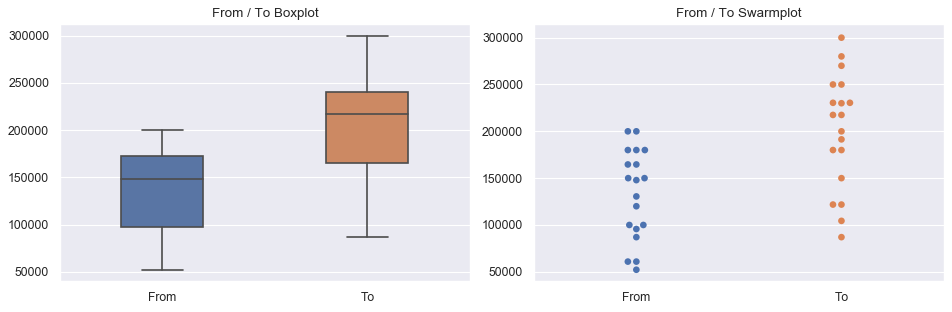

In [7]:
fz = plt.figure(figsize=(12, 4), dpi=80)
ax = fz.add_subplot(1, 2, 1)
plt.title('From / To Boxplot')
sns.boxplot(data=df[['From', 'To']].dropna(), width=0.4)
ax = fz.add_subplot(1, 2, 2)
plt.title('From / To Swarmplot')
sns.swarmplot(data=df[['From', 'To']].dropna(), size=6)
plt.tight_layout()
plt.savefig('from_to.png')

### Усредненная статистика

Поскольку не у всех вакансий указаны поля "От" и "До", производится расчет средней зарплаты, а на основании этих данных рассчитывается статистика.

In [8]:
comb_from_to = np.nanmean(df[df['Salary']][['From', 'To']].to_numpy(), axis=1)
print('Average statistics (average filter for "From"-"To" parameters):')
print('Mim    : %d' % np.min(comb_from_to))
print('Max    : %d' % np.max(comb_from_to))
print('Mean   : %d' % np.mean(comb_from_to))
print('Median : %d' % np.median(comb_from_to))

Average statistics (average filter for "From"-"To" parameters):
Mim    : 20000
Max    : 401000
Mean   : 175482
Median : 174000


### Список часто используемых слов

В этом разделе производится поиск наиболее употребляемых слов для параметра **Ключевые навыки**. Результа функции - список в порядке убывания.

In [9]:
def most_keys():
    # Collect keys from dataframe
    keys_df = df['Keys'].to_list()
    
    # Create a list of keys for all vacancies
    lst_keys = []
    for keys_elem in keys_df:
        for el in keys_elem[1:-1].split(', '):
            if el != '':
                lst_keys.append(re.sub('\'', '', el.lower()))

    # Unique keys and their counter
    set_keys = set(lst_keys)
    # Dict: {Key: Count}
    dct_keys = {el:lst_keys.count(el) for el in set_keys}
    # Sorted dict
    srt_keys = dict(sorted(dct_keys.items(), key=lambda x: x[1], reverse=True))
    # Return pandas series
    return pd.Series(srt_keys, name='Keys')

In [10]:
ds_keys = most_keys()

print(ds_keys[:15])

python                       91
machine learning             56
sql                          35
data mining                  26
c++                          25
big data                     23
java                         21
математическая статистика    19
javascript                   19
data analysis                18
data science                 16
linux                        15
tensorflow                   13
английский язык              13
deep learning                13
Name: Keys, dtype: int64


### Описание вакансий

Поиск наиболее употребляемых слов для параметра **Описание вакансий**.  
Результат функции - список наиболее часто употребляемых слов (на английском языке) в порядке убывания.

In [11]:
def most_words():
    # Collect keys from dataframe
    words_df = df['Description'].to_list()
    # Long string - combine descriptions
    words_ls = ' '.join([re.sub(' +', ' ', re.sub('\d+', '', el.strip().lower())) for el in words_df])
    # Find all words
    words_re = re.findall('[a-zA-Z]+', words_ls)
    # Filter words with length < 3
    words_l2 = [el for el in words_re if len(el) > 2]
    # Unique words
    words_st = set(words_l2)
    # Remove 'stop words'
    stop_words = set(stopwords.words('english'))
    # XOR for dictionary
    words_st ^= stop_words
    # Dictionary - {Word: Counter}
    words_cnt = {el : words_l2.count(el) for el in words_st}
    # Pandas series
    return pd.Series(dict(sorted(words_cnt.items(), key=lambda x: x[1], reverse=True)))

In [12]:
ds_words = most_words()

print(ds_words.head(15))

data           646
learning       496
experience     413
machine        367
python         241
business       235
team           227
skills         206
development    192
work           157
knowledge      146
amp            144
science        142
solutions      138
sql            132
dtype: int64


### Предсказание зарплаты

На этом этапе происходит предсказание зарплаты для вакансий, у которых она не указана. Ниже пошагово представлен алгоритм.
___

**Шаг 1: Предобработка данных**:
- Удаление NaN значений из таблицы,
- Поиск среднего значение для From / To столбцов,
- Замена столбцов зарплаты на усредненое значение

In [13]:
# Replace NaN from Salary into From / To fields,
# Find mean values for each elemen and drop NaNs
df_num = df[df['From'].notna() | df['From'].notna()]
df_avg = df_num[['From', 'To']].mean(axis=1)
df_num = df_num.drop(['Salary', 'From', 'To'], axis=1)
df_num.insert(3, 'Average', df_avg)

**Шаг 2: Подготовка модели**:
- Формирование вектора признаков из столбца ключевых навыков со списком исключений `stop_words`
- Поиск наиболее часто используемых слов в ключевых навыках
- One-Hot кодирование признаков таблицы
- Объединение в матрицу "объекты-признаки"

In [14]:
def text_replace(text) -> pd.Series:
    return text.str.lower().replace("[^a-zA-Z]\bqout\b|\bamp\b", " ", regex=True)

# Set TF-IDF features
min_df = 5 # ignore terms w/ frequency < than threshold
tf_idf = TfidfVectorizer(min_df=min_df, stop_words='english')

# Training set
X_train_text = tf_idf.fit_transform(text_replace(df_num['Keys']))
# Dict: {key: counter}
# print(pd.Series(tf_idf.vocabulary_)[:10])

# Print top words used in keys
idx = np.ravel(X_train_text.sum(axis=0).argsort(axis=1))[::-1][:7]
top_words = np.array(tf_idf.get_feature_names())[idx].tolist()
print('Top words used in keys: {}'. format(top_words))

# One-hot-encoding for data frame features
dct_enc = DictVectorizer()
X_train_cat = dct_enc.fit_transform(df_num[['Experience', 'Name']].to_dict('Records'))

# Stack vectors
X_train = hstack([X_train_text, X_train_cat])

Top words used in keys: ['python', 'learning', 'analysis', 'java', 'sql', 'data', 'machine']


**Шаг 3: Обучение модели**

In [15]:
# Train model
y_train = df_num['Average']
model = Ridge(alpha=1, random_state=255)
model.fit(X_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=255, solver='auto', tol=0.001)

**Шаг 4: Применение к тестовым данным**

In [16]:
# Frame with NaNs
x_test = df[df['From'].isna() & df['To'].isna()]

# Test vectors
X_test_text = tf_idf.transform(text_replace(x_test['Description']))
X_test_cat = dct_enc.transform(x_test[['Experience', 'Name']].to_dict('Records'))
X_test = hstack([X_test_text, X_test_cat])

# Prediction model - result
y_test = model.predict(X_test)

print('Average salary forvacancies with NaN is {}'.format(y_test.mean(dtype=int)))

Average salary forvacancies with NaN is 181676


**Шаг 5: Замена отсутствующих зарплат на предсказанные значения**

In [17]:
df_tst = x_test.drop(['Salary', 'From', 'To'], axis=1)
df_tst.insert(3, 'Average', y_test.astype(int))
df_tst.head(10)

,Id,Employer,Name,Average,Experience,Schedule,Keys,Description
0,32614314,HUAWEI,Machine Learning Engineer,123041,Нет опыта,Полный день,"['deep learning', 'machine vision', 'image rec...",Кто нам нужен: Специалист в области deep learn...
1,32728825,Хидбук Клауд,Machine Learning Engineer / инженер машинного ...,192406,От 1 года до 3 лет,Полный день,"['tensorflow', 'Python']","Привет!Мы в компании Heedbook, помимо прочего,..."
2,33080773,ОНСЕК,Machine Learning Engineer,120520,Нет опыта,Полный день,"['Python', 'НТТР', 'REST API', 'JSON', 'C++', ...",Что такое Валарм? Компания Валарм - разработчи...
3,32000237,НТехЛаб,Senior Machine Learning Engineer,199646,От 3 до 6 лет,Полный день,[],"NtechLab – молодая компания, мы разрабатываем ..."
5,31934468,Samsung Research Center,Machine Learning Engineer,200860,От 3 до 6 лет,Полный день,"['Machine Learning', 'Deep Learning', 'Python'...",Responsibilities: Develop and prototype appl...
6,33014092,Генотек,Data scientist,196415,От 1 года до 3 лет,Полный день,[],"Genotek – молодая компания, знающая толк в тех..."
7,33013367,АЙКЬЮВИА СОЛЮШНС,Machine Learning Analyst,169035,От 1 года до 3 лет,Полный день,"['Latex', 'SQL', 'MATLAB', 'Английский язык', ...",IQVIA is the world’s largest provider of bioph...
8,32984434,BOSCH,Machine Learning Research Engineer,195495,От 3 до 6 лет,Полный день,"['MATLAB', 'C++', 'Python', 'Математическое мо...",Do you have deep experience in machine learnin...
9,32717834,Ton Labs,Senior Data Scientist,215263,Более 6 лет,Полный день,"['Data Analysis', 'Data Mining', 'Analytical s...",TVS is looking to implement an innovative new ...
10,32667835,Билайн,Data scientist,186497,От 1 года до 3 лет,Полный день,[],"Наше подразделение - это команда, объединённая..."


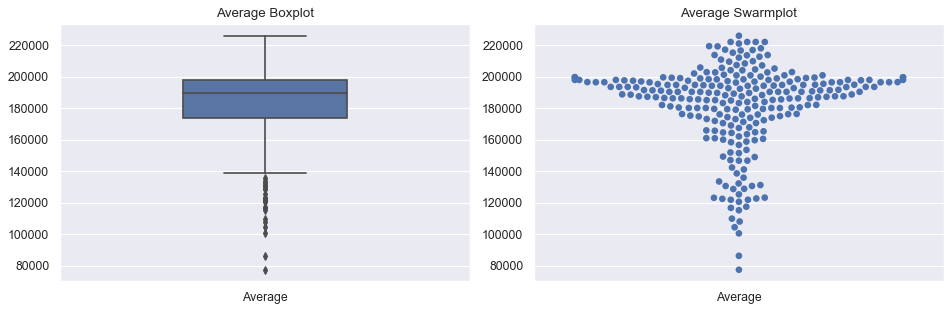

In [18]:
fz = plt.figure(figsize=(12, 4), dpi=80)
fz.add_subplot(1, 2, 1)
plt.title('Average Boxplot')
sns.boxplot(data=df_tst[['Average']], width=0.4)
fz.add_subplot(1, 2, 2)
plt.title('Average Swarmplot')
sns.swarmplot(data=df_tst[['Average']].dropna(), size=6)
plt.tight_layout()